This notebook has an example of producing similar PCA outputs as in the DINOv2 demos, where the background is first thresholded out and PCA is calculated for only the foreground patches. The demos also calculate the PCA over multiple images, highlighting similar feature across the images.

In [ ]:
!dinotool ../test/data/bird1.jpg -o bird1.jpg --save-features 'full'
!dinotool ../test/data/bird2.jpg -o bird2.jpg --save-features 'full'
!dinotool ../test/data/bird3.jpg -o bird3.jpg --save-features 'full'

Using cache found in /home/mikko/.cache/torch/hub/facebookresearch_dinov2_main
Using model: dinov2_vits14_reg
Input size: (896, 896)
Feature map size: (64, 64)
Using device: cuda
Fitted PCA with 3 components
Explained variance ratio: [0.33215761 0.09451494 0.07443471]
Saved visualization to bird1.jpg
Saved features to bird1.nc
Using cache found in /home/mikko/.cache/torch/hub/facebookresearch_dinov2_main
Using model: dinov2_vits14_reg
Input size: (896, 896)
Feature map size: (64, 64)
Using device: cuda
Fitted PCA with 3 components
Explained variance ratio: [0.2563493  0.1695929  0.09336824]
Saved visualization to bird2.jpg
Saved features to bird2.nc
Using cache found in /home/mikko/.cache/torch/hub/facebookresearch_dinov2_main
Using model: dinov2_vits14_reg
Input size: (896, 896)
Feature map size: (64, 64)
Using device: cuda
Fitted PCA with 3 components
Explained variance ratio: [0.23088938 0.15144625 0.08544052]
Saved visualization to bird3.jpg
Saved features to bird3.nc


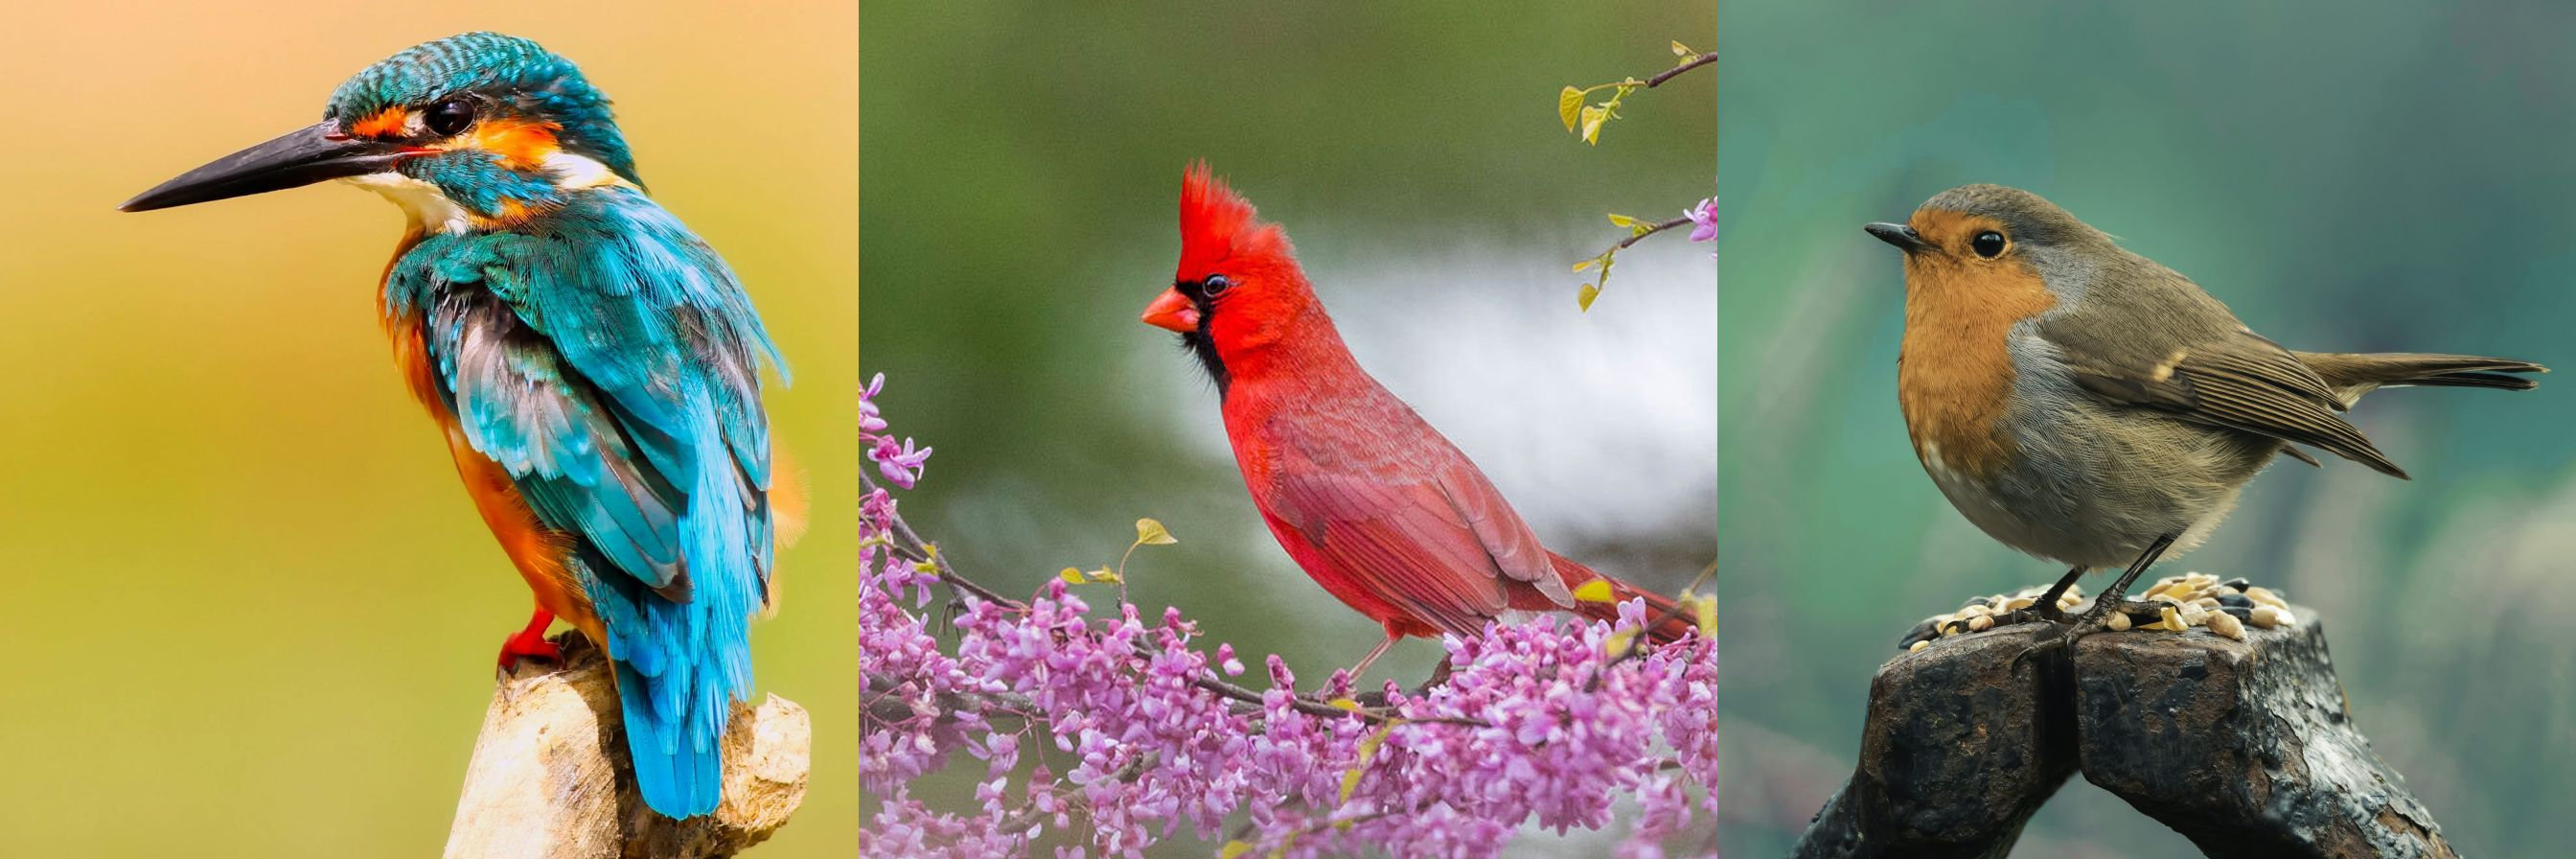

In [2]:
import numpy as np
from PIL import Image
from einops import rearrange
all_images = [Image.open("../test/data/bird1.jpg"),
              Image.open("../test/data/bird2.jpg"),
              Image.open("../test/data/bird3.jpg")]
all_images = np.concat([np.array(x) for x in all_images], axis=1)
Image.fromarray(all_images)

In [3]:
import xarray
# All are 64x64 for simplicity in this demo
A1 = xarray.open_dataarray("bird1.nc").sel(frame_idx=0)
A2 = xarray.open_dataarray("bird2.nc").sel(frame_idx=0)
A3 = xarray.open_dataarray("bird3.nc").sel(frame_idx=0)

In [4]:
a1 = rearrange(A1.values, "h w c -> (h w) c")
a2 = rearrange(A2.values, "h w c -> (h w) c")
a3 = rearrange(A3.values, "h w c -> (h w) c")
print(len(a1), len(a2), len(a3))

4096 4096 4096


In [5]:
import numpy as np
all_features = np.concat((a1,a2,a3), axis=0)
all_features

array([[-0.08006093,  0.0718392 ,  0.07243302, ..., -0.00327937,
        -0.03581236,  0.11173344],
       [-0.07200103,  0.07594731,  0.08434096, ..., -0.00524411,
        -0.03458421,  0.11306894],
       [-0.08640611,  0.07310593,  0.09497715, ..., -0.00729643,
        -0.03294026,  0.11516441],
       ...,
       [-0.07583442,  0.00979398,  0.10913705, ...,  0.02612005,
        -0.02069712,  0.10177255],
       [-0.06133968,  0.02795228,  0.12535907, ...,  0.03352125,
        -0.02279607,  0.10053971],
       [-0.05428731,  0.01656462,  0.13586296, ...,  0.02973971,
        -0.02506689,  0.10113794]], shape=(12288, 384), dtype=float32)

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=3).fit_transform(all_features)

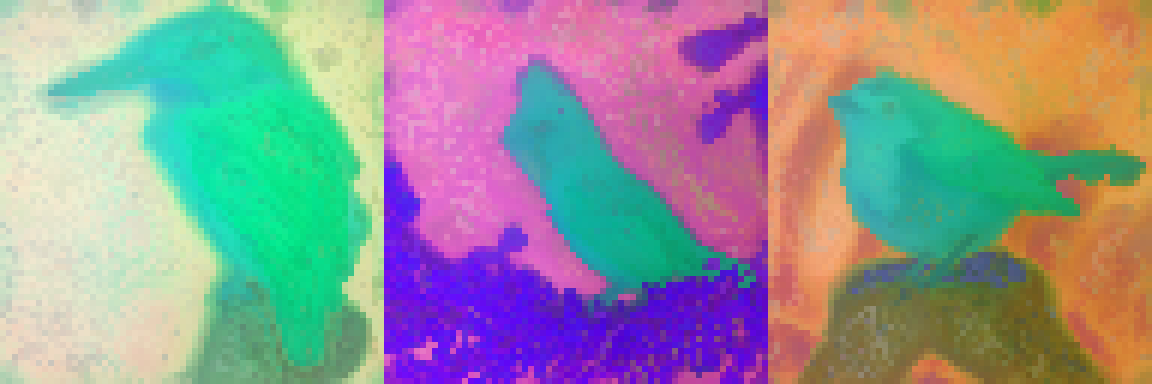

In [7]:
def normalize(a, uint8=True):
    a = a - a.min()
    a = a/a.max()
    if uint8:
        a = (a*255).astype(np.uint8)
        return a
    return a
def make_image(img):
    img = Image.fromarray(img)
    return img.resize((img.size[0]*6, img.size[1]*6), resample=Image.NEAREST)

pca2d = rearrange(pca, "(b h w) c -> h (b w) c", b=3, h=64, w=64, c=3)
make_image(normalize(pca2d))

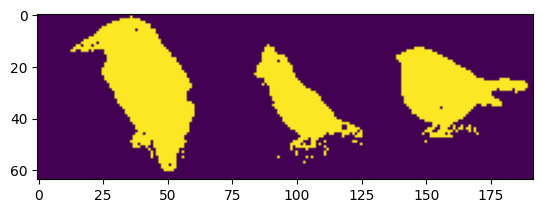

In [8]:
mask = normalize(pca[:,0], uint8=False) < 0.3
mask2d = rearrange(mask, "(b h w) -> h (b w)", h=64, w=64)
plt.imshow(mask2d)

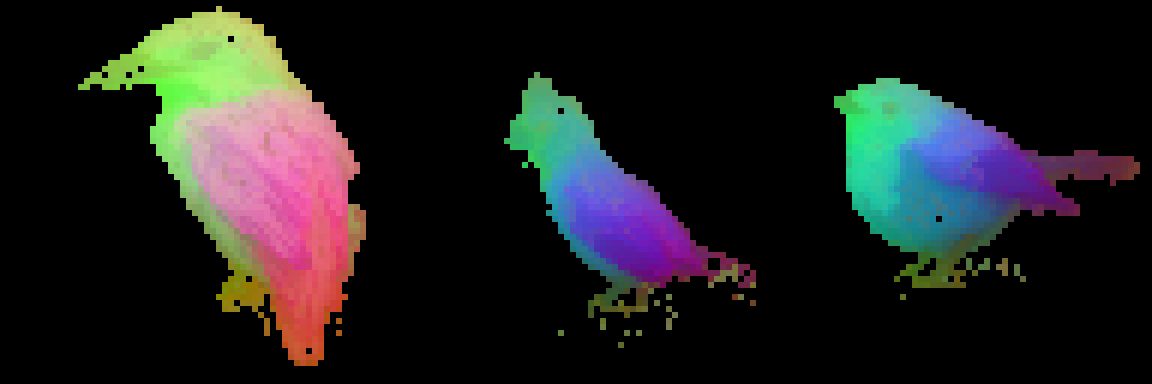

In [9]:
pca_fg_values = PCA(n_components=3).fit_transform(all_features[mask.reshape(-1)])
pca_fg_values = normalize(pca_fg_values)

pca_fg = np.zeros((len(all_features), 3)).astype(np.uint8)
pca_fg[mask.reshape(-1)] = pca_fg_values

a = rearrange(pca_fg, "(b h w) c -> h (b w) c", h=64, w=64, b=3, c=3)
make_image(a)

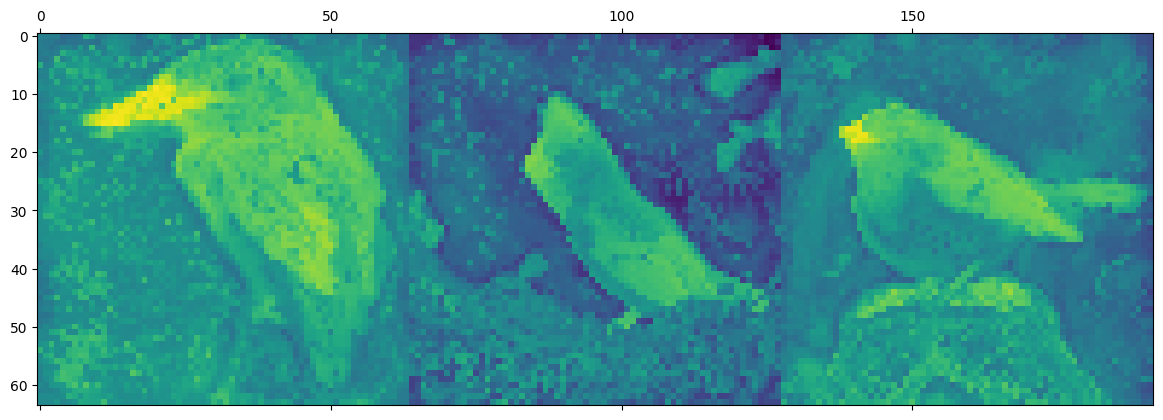

In [10]:
# Visualization of a single feature
plt.matshow(rearrange(all_features, "(b h w) c -> c h (b w)", h=64, w=64)[150])